<a href="https://colab.research.google.com/github/truongvanthanh95/Recommender-System-CDIO/blob/main/CBF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!curl https://files.grouplens.org/datasets/movielens/ml-latest-small.zip --output data.zip
!unzip data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0   419k      0  0:00:02  0:00:02 --:--:--  419k
Archive:  data.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.svm import SVR

In [ ]:
ratings = pd.read_csv("ml-latest-small/ratings.csv")
tags = pd.read_csv("ml-latest-small/tags.csv")

In [ ]:
movie_tags = pd.crosstab(tags.movieId, tags.tag)

In [ ]:
movie_vectors = movie_tags.to_numpy()
from sklearn.preprocessing import StandardScaler
movie_vectors = StandardScaler().fit_transform(movie_vectors)
print("Chiều item profile trước khi giảm chiều: ", movie_vectors.shape)
from sklearn.decomposition import PCA
pca = PCA(n_components = 50)
final_movie_vectors = pca.fit_transform(movie_vectors)
print("Chiều item profile sau khi giảm chiều: ", final_movie_vectors.shape)

Chiều item profile trước khi giảm chiều:  (1572, 1589)
Chiều item profile sau khi giảm chiều:  (1572, 50)


In [ ]:
userId = list(set(ratings.userId.values))
movieId_lookup = {}
movieId_inver_lookup = {}
for idx, movieId in enumerate(list(movie_tags.index)):
  movieId_lookup[movieId] = idx
  movieId_inver_lookup[idx] = movieId
count_ratings = ratings.groupby('userId')['movieId'].count()

In [ ]:
data = ratings.sample(frac=1, random_state=24).reset_index(drop=True)
train_movies = {user: set() for user in userId}
train_input = {user: [] for user in userId}
train_output = {user: [] for user in userId}
test_input = {user: [] for user in userId}
test_output = {user: [] for user in userId}
test_movies = {user: set() for user in userId}
cnt_lk = {user: 0 for user in userId}
for t in data.values.tolist():
  curr_user = t[0]
  curr_movie = int(t[1])
  curr_ratings = t[2]
  if curr_movie not in movieId_lookup:
    continue
  if count_ratings[curr_user] <= 5:
    train_input[curr_user].append(final_movie_vectors[movieId_lookup[curr_movie]])
    train_output[curr_user].append(curr_ratings)
    train_movies[curr_user].add((curr_movie, curr_ratings))
  else:
    if cnt_lk[curr_user] < 0.8 * count_ratings[curr_user]:
      train_input[curr_user].append(final_movie_vectors[movieId_lookup[curr_movie]])
      train_output[curr_user].append(curr_ratings)
      train_movies[curr_user].add((curr_movie, curr_ratings))
      cnt_lk[curr_user] += 1
    else:
      test_input[curr_user].append(final_movie_vectors[movieId_lookup[curr_movie]])
      test_output[curr_user].append(curr_ratings)
      test_movies[curr_user].add((curr_movie, curr_ratings))

In [ ]:
AVERAGE_RATING = ratings.rating.mean()
RELEVANT_THRESHOLD = 3

In [ ]:
class SVRContentRecommender:
  def __init__(self, kernel='rbf'):
    self.model = {user: SVR(kernel=kernel) for user in userId}
  

  def fit(self, train_input, train_output):
    for user in userId:
      if train_input[user]:
        self.model[user].fit(train_input[user], train_output[user])


  def rmse(self, test_input, test_output):
    total = 0
    total_cnt = 0
    for user in userId:
      if test_input[user] and train_input[user]:
        test_predict = self.model[user].predict(test_input[user])
        for i in range(len(test_predict)):
          if test_predict[i] < 1:
            test_predict[i] = 1
          elif test_predict[i] > 5:
            test_predict[i] = 5
        test_output[user] = np.array(test_output[user])
        total += ((test_predict - test_output[user]) ** 2).sum()
        total_cnt += len(test_input[user])
    return np.sqrt(total / total_cnt)


  def ap10(self, user, train_movies, test_movies):
    curr_relevant_set = set()
    watched_movies = set()
    for entry in test_movies[user]:
      if entry[1] >= RELEVANT_THRESHOLD:
        curr_relevant_set.add(entry[0])
    for entry in train_movies[user]:
      watched_movies.add(entry[0])
    curr_scores = self.model[user].predict(final_movie_vectors)
    sorted_movies = (-curr_scores).argsort()
    total_rec = 0
    curr_hit = 0
    curr_precision = 0
    ap = 0
    for idx in sorted_movies:
      if total_rec == 10:
        break
      if movieId_inver_lookup[idx] in watched_movies:
        continue
      total_rec += 1
      if movieId_inver_lookup[idx] in curr_relevant_set:
        curr_hit += 1
        curr_precision += curr_hit / total_rec
    if len(curr_relevant_set) > 0:
        ap = 1 / len(curr_relevant_set) * curr_precision
    return ap

  def hitrate_user(self, user, train_movies, test_movies):
    total_cnt = len(test_input[user])
    watched_movies = set()

    for entry in train_movies[user]:
      watched_movies.add(entry[0])
    goal_movies = set()
    for entry in test_movies[user]:
      goal_movies.add(entry[0])
    curr_scores = self.model[user].predict(final_movie_vectors)
    sorted_movies = (-curr_scores).argsort()
    total_rec = 0
    curr_hit = 0
    for idx in sorted_movies:
      if total_rec == 10:
        break
      if movieId_inver_lookup[idx] in watched_movies:
        continue
      total_rec += 1
      if movieId_inver_lookup[idx] in goal_movies:
        curr_hit += 1 / total_rec
        break
    return curr_hit

  def hitrate(self, train_movies, test_movies):
    hit = 0
    for user in userId:
      hit += self.hitrate_user(user, train_movies, test_movies)
    return hit / len(userId)

  def map10(self, train_movies, test_movies):
    map = 0
    for user in userId:
      map += self.ap10(user, train_movies, test_movies)
    return map / len(userId)


  def predict(self, user, movie):
    if movie not in movieId_lookup:
      return AVERAGE_RATING
    predict_rating = self.model[user].predict([final_movie_vectors[movieId_lookup[movie]]])
    return np.maximum(np.minimum(5, predict_rating), 0.5)[0]

In [ ]:
model = SVRContentRecommender()

In [ ]:
model.fit(train_input, train_output)

In [ ]:
model.predict(1, 1)

4.902423877299508

In [ ]:
model.rmse(test_input, test_output)

1.0896051673782754

In [ ]:
model.map10(train_movies, test_movies)

0.0

In [ ]:
model.hitrate(train_movies, test_movies)

0.0

In [ ]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
rmse = []
map10 = []
hitrate = []
for kernel in kernels:
  model = SVRContentRecommender(kernel=kernel)
  model.fit(train_input, train_output)
  rmse.append(model.rmse(test_input, test_output))
  map10.append(model.map10(train_movies, test_movies))
  hitrate.append(model.hitrate(train_movies, test_movies))
  

Text(0, 0.5, 'RMSE')

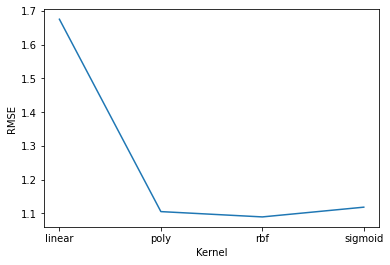

In [ ]:
plt.plot(kernels, rmse)
plt.xlabel("Kernel")
plt.ylabel("RMSE")

Text(0, 0.5, 'map10')

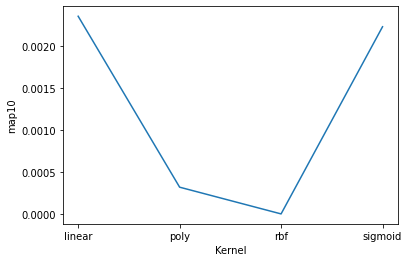

In [ ]:
plt.plot(kernels, map10)
plt.xlabel("Kernel")
plt.ylabel("map10")

Text(0, 0.5, 'hitrate')

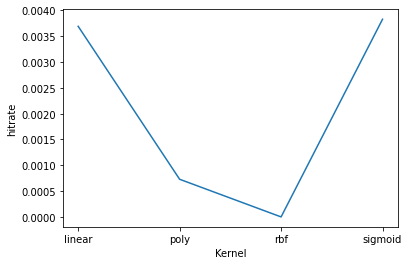

In [ ]:
plt.plot(kernels, hitrate)
plt.xlabel("Kernel")
plt.ylabel("hitrate")

In [ ]:
class RidgeContentRecommender:
  def __init__(self, alpha=1):
    self.model = {user: Ridge(alpha=alpha) for user in userId}
  

  def fit(self, train_input, train_output):
    for user in userId:
      if train_input[user]:
        self.model[user].fit(train_input[user], train_output[user])


  def rmse(self, test_input, test_output):
    total = 0
    total_cnt = 0
    for user in userId:
      if test_input[user] and train_input[user]:
        test_predict = self.model[user].predict(test_input[user])
        for i in range(len(test_predict)):
          if test_predict[i] < 1:
            test_predict[i] = 1
          elif test_predict[i] > 5:
            test_predict[i] = 5
        test_output[user] = np.array(test_output[user])
        total += np.sqrt((test_predict - test_output[user]) ** 2).sum()
        total_cnt += len(test_input[user])
    return total / total_cnt


  def ap10(self, user, train_movies, test_movies):
    curr_relevant_set = set()
    watched_movies = set()
    for entry in test_movies[user]:
      if entry[1] >= RELEVANT_THRESHOLD:
        curr_relevant_set.add(entry[0])
    for entry in train_movies[user]:
      watched_movies.add(entry[0])
    curr_scores = self.model[user].predict(final_movie_vectors)
    sorted_movies = (-curr_scores).argsort()
    total_rec = 0
    curr_hit = 0
    curr_precision = 0
    ap = 0
    for idx in sorted_movies:
      if total_rec == 10:
        break
      if movieId_inver_lookup[idx] in watched_movies:
        continue
      total_rec += 1
      if movieId_inver_lookup[idx] in curr_relevant_set:
        curr_hit += 1
        curr_precision += curr_hit / total_rec
    if len(curr_relevant_set) > 0:
        ap = 1 / len(curr_relevant_set) * curr_precision
    return ap

  def hitrate_user(self, user, train_movies, test_movies):
    total_cnt = len(test_input[user])
    watched_movies = set()

    for entry in train_movies[user]:
      watched_movies.add(entry[0])
    goal_movies = set()
    for entry in test_movies[user]:
      goal_movies.add(entry[0])
    curr_scores = self.model[user].predict(final_movie_vectors)
    sorted_movies = (-curr_scores).argsort()
    total_rec = 0
    curr_hit = 0
    for idx in sorted_movies:
      if total_rec == 10:
        break
      if movieId_inver_lookup[idx] in watched_movies:
        continue
      total_rec += 1
      if movieId_inver_lookup[idx] in goal_movies:
        curr_hit += 1 / total_rec
        break
    return curr_hit

  def hitrate(self, train_movies, test_movies):
    hit = 0
    for user in userId:
      hit += self.hitrate_user(user, train_movies, test_movies)
    return hit / len(userId)

  def map10(self, train_movies, test_movies):
    map = 0
    for user in userId:
      map += self.ap10(user, train_movies, test_movies)
    return map / len(userId)


  def predict(self, user, movie):
    if movie not in movieId_lookup:
      return AVERAGE_RATING
    predict_rating = self.model[user].predict([final_movie_vectors[movieId_lookup[movie]]])
    return np.maximum(np.minimum(5, predict_rating), 0.5)[0]

In [ ]:
alphas = np.arange(0.1, 20, 0.5)
rmse = []
map10 = []
hitrate = []
for alpha in alphas:
  model = RidgeContentRecommender(alpha=alpha)
  model.fit(train_input, train_output)
  rmse.append(model.rmse(test_input, test_output))
  map10.append(model.map10(train_movies, test_movies))
  hitrate.append(model.hitrate(train_movies, test_movies))

Text(0, 0.5, 'RMSE')

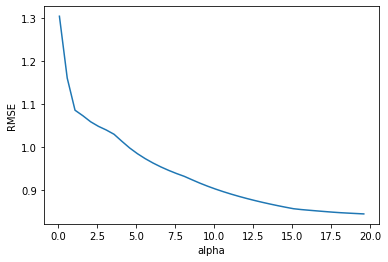

In [ ]:
plt.plot(alphas, rmse)
plt.xlabel("alpha")
plt.ylabel("RMSE")

Text(0, 0.5, 'map10')

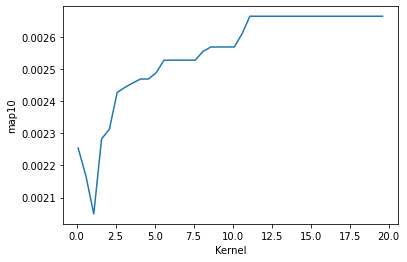

In [ ]:
plt.plot(alphas, map10)
plt.xlabel("Kernel")
plt.ylabel("map10")

Text(0, 0.5, 'hitrate')

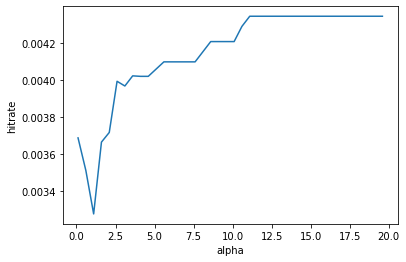

In [ ]:
plt.plot(alphas, hitrate)
plt.xlabel("alpha")
plt.ylabel("hitrate")